In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

d:\MiniConda\envs\torch-gpu\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 347s 184ms/step - accuracy: 0.3800 - loss: 1.6048 - val_accuracy: 0.5117 - val_loss: 1.1396
Epoch 2/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 326s 176ms/step - accuracy: 0.5204 - loss: 1.1333 - val_accuracy: 0.5474 - val_loss: 1.0531
Epoch 3/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 318s 171ms/step - accuracy: 0.5532 - loss: 1.0466 - val_accuracy: 0.5786 - val_loss: 0.9851
Epoch 4/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 349s 188ms/step - accuracy: 0.5748 - loss: 0.9971 - val_accuracy: 0.5724 - val_loss: 0.9771
Epoch 5/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 334s 180ms/step - accuracy: 0.5870 - loss: 0.9606 - val_accuracy: 0.5893 - val_loss: 0.9594
Epoch 6/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 300s 161ms/step - accuracy: 0.6008 - loss: 0.9316 - val_accuracy: 0.6068 - val_loss: 0.9124
Epoch 7/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 300s 162ms/step - accuracy: 0.6126 - loss: 0.8989 - val_accuracy: 0.6052 - val_loss: 0.9208
Epoch 8/50
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 323s 174ms/step - ac

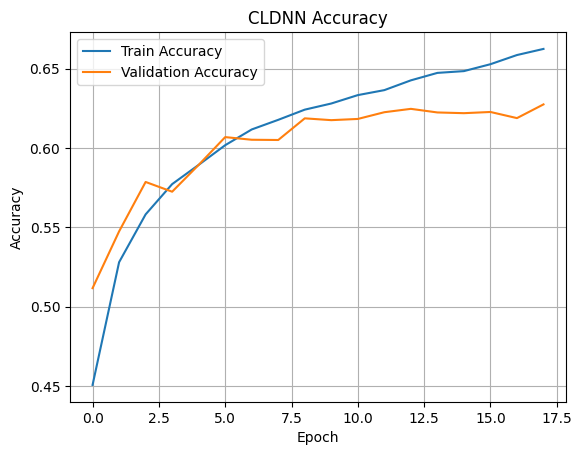

In [6]:

# Load dataset
with open("RML2016.10a/RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")


# Preprocess: filter SNR >= -10, normalize per sample
X, labels = [], []
for (mod, snr), samples in data.items():
    if int(snr) >= -10:
        for s in samples:
            s = s - np.mean(s, axis=1, keepdims=True)
            s = s / (np.std(s, axis=1, keepdims=True) + 1e-9)
            X.append(s)
            labels.append(mod)

X = np.array(X).transpose(0, 2, 1)  # (n_samples, 128, 2)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# Build CLDNN
def build_cldnn(input_shape=(128, 2), num_classes=8):
    model = Sequential()
    model.add(Conv1D(64, 5, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(LSTM(128))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cldnn(input_shape=(128, 2), num_classes=len(np.unique(y)))

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

# Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("CLDNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
model.save("cldnn_modulation_classifier.h5")


In [13]:
pip install tf2onnx onnx


Note: you may need to restart the kernel to use updated packages.


In [17]:
import tensorflow as tf
import tf2onnx
import onnx

# Step 1: Save as SavedModel format (not .h5)
model.save("saved_cldnn_model.keras")

# Step 2: Convert SavedModel to ONNX
!python -m tf2onnx.convert --saved-model "saved_cldnn_model.keras" --output "cldnn_modulation_classifier.onnx" --opset 13




<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-04-09 18:30:08,026 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-04-09 18:30:08,028 - WARNING - '--tag' not specified for saved_model. Using --tag serve
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\MiniConda\envs\torch-gpu\Lib\site-packages\tf2onnx\convert.py", line 714, in <module>
    main()
  File "d:\MiniConda\envs\torch-gpu\Lib\site-packages\tf2onnx\convert.py", line 242, in main
    graph_def, inputs, outputs, initialized_tables, tensors_to_rename = tf_loader.from_saved_model(
                                                                        ^^^^^^^^

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step


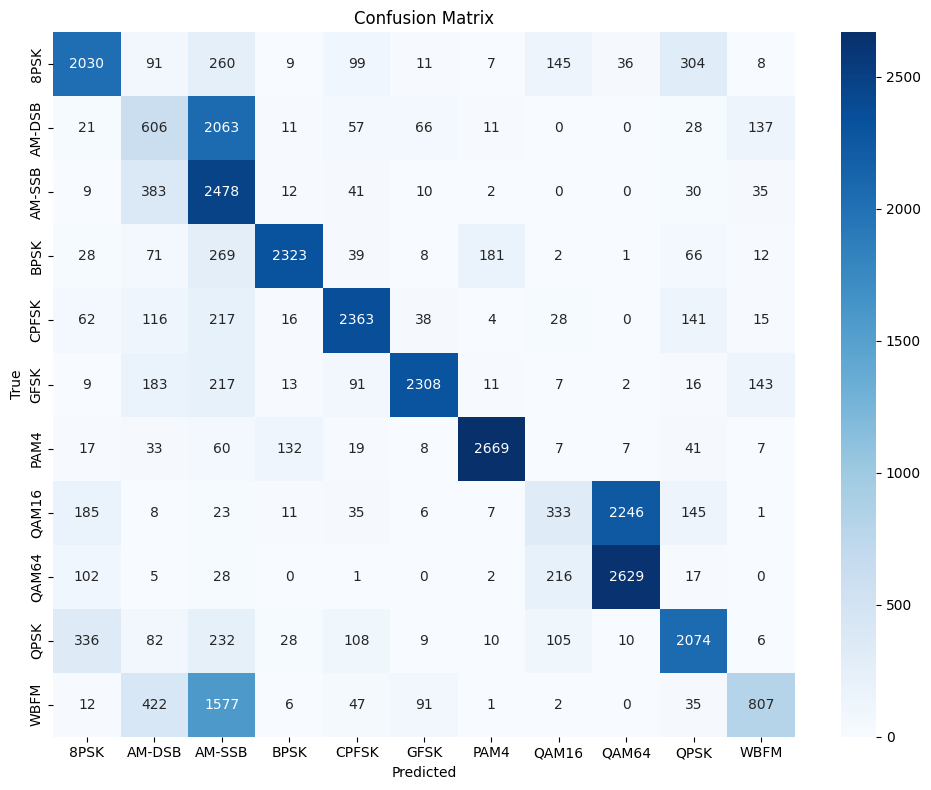

📊 Classification Report:
               precision    recall  f1-score   support

        8PSK       0.72      0.68      0.70      3000
      AM-DSB       0.30      0.20      0.24      3000
      AM-SSB       0.33      0.83      0.48      3000
        BPSK       0.91      0.77      0.84      3000
       CPFSK       0.81      0.79      0.80      3000
        GFSK       0.90      0.77      0.83      3000
        PAM4       0.92      0.89      0.90      3000
       QAM16       0.39      0.11      0.17      3000
       QAM64       0.53      0.88      0.66      3000
        QPSK       0.72      0.69      0.70      3000
        WBFM       0.69      0.27      0.39      3000

    accuracy                           0.62     33000
   macro avg       0.66      0.62      0.61     33000
weighted avg       0.66      0.62      0.61     33000



In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_classes, target_names=le.classes_)
print("📊 Classification Report:\n", report)


In [1]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle

model = load_model("cldnn_modulation_classifier.h5")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array([
    '16QAM', '64QAM', '8PSK', 'AM-DSB',
    'BPSK', 'CPFSK', 'GFSK', 'PAM4',
    'QAM16', 'QAM64', 'QPSK'
])




In [2]:
def generate_test_iq(mod_type, num_symbols=128):
    mod_type = mod_type.upper()
    if mod_type == "BPSK":
        bits = np.random.randint(0, 2, num_symbols)
        symbols = 2 * bits - 1
        iq = np.array([symbols, np.zeros_like(symbols)])
    elif mod_type == "QPSK":
        bits = np.random.randint(0, 4, num_symbols)
        angles = np.pi/4 + bits * np.pi/2
        iq_complex = np.exp(1j * angles)
        iq = np.array([np.real(iq_complex), np.imag(iq_complex)])
    elif mod_type == "8PSK":
        bits = np.random.randint(0, 8, num_symbols)
        angles = bits * 2 * np.pi / 8
        iq_complex = np.exp(1j * angles)
        iq = np.array([np.real(iq_complex), np.imag(iq_complex)])
    elif mod_type == "16QAM":
        re = 2 * (np.random.randint(0, 4, num_symbols) - 1.5)
        im = 2 * (np.random.randint(0, 4, num_symbols) - 1.5)
        iq = np.array([re, im])
    elif mod_type == "64QAM":
        re = 2 * (np.random.randint(0, 8, num_symbols) - 3.5)
        im = 2 * (np.random.randint(0, 8, num_symbols) - 3.5)
        iq = np.array([re, im])
    elif mod_type == "GFSK" or mod_type == "CPFSK":
        phase = np.cumsum(2 * np.pi * (np.random.randint(0, 2, num_symbols) * 2 - 1) * 0.1)
        iq_complex = np.exp(1j * phase)
        iq = np.array([np.real(iq_complex), np.imag(iq_complex)])
    elif mod_type == "PAM4":
        levels = [-3, -1, 1, 3]
        symbols = np.random.choice(levels, size=num_symbols)
        iq = np.array([symbols, np.zeros_like(symbols)])
    else:
        raise ValueError(f"Unsupported modulation type: {mod_type}")

    iq = iq / np.sqrt(np.mean(iq**2))
    return iq.astype(np.float32)


In [5]:
def preprocess_iq_signal(iq_sample):
    iq_sample = iq_sample - np.mean(iq_sample, axis=1, keepdims=True)
    iq_sample = iq_sample / (np.std(iq_sample, axis=1, keepdims=True) + 1e-9)
    return iq_sample.T.reshape(1, 128, 2)

# Simulated (2,128) I/Q signal
iq_input = np.random.randn(2, 128).astype(np.float32)
processed_iq = preprocess_iq_signal(iq_input)


In [11]:
def predict_modulation(iq_sample):
    pred = model.predict(iq_sample)
    mod_class = np.argmax(pred, axis=1)[0]
    return label_encoder.inverse_transform([mod_class])[0]


In [12]:
mod_schemes = {
    1: '16QAM',
    2: '64QAM',
    3: '8PSK',
    4: 'BPSK',
    5: 'CPFSK',
    6: 'GFSK',
    7: 'PAM4',
    8: 'QPSK'
}

test_signals = {}

i=1
for key, mod in mod_schemes.items():
    test_signals[key] = generate_test_iq(mod, num_symbols=128)
    print(f"Generated signal {key} : shape {test_signals[key].shape}")
    i+=1


Generated signal 1 : shape (2, 128)
Generated signal 2 : shape (2, 128)
Generated signal 3 : shape (2, 128)
Generated signal 4 : shape (2, 128)
Generated signal 5 : shape (2, 128)
Generated signal 6 : shape (2, 128)
Generated signal 7 : shape (2, 128)
Generated signal 8 : shape (2, 128)


In [13]:
# scheme_to_print = "16QAM"  # Change this to the modulation scheme you want to print

# if scheme_to_print in test_signals:
#     print(f"Data for {scheme_to_print}:")
#     print(test_signals[scheme_to_print])
# else:
#     print(f"Modulation scheme '{scheme_to_print}' not found in test_signals.")

In [30]:
key = 5

# Access modulation scheme name
modulation_scheme = mod_schemes.get(key, "Unknown Modulation")

# Access corresponding signal (key is already int, no need to convert)
iq_input = test_signals[key]

# Preprocess and predict
processed = preprocess_iq_signal(iq_input)
predicted_mod = predict_modulation(processed)

print("🔍 Predicted Modulation:", predicted_mod)
# # print(f"📡 True Modulation Scheme: {modulation_scheme}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🔍 Predicted Modulation: 16QAM


In [31]:
def generate_synthetic_iq(mod_type, num_symbols=128):
    mod_type = mod_type.upper()
    if mod_type == "BPSK":
        bits = np.random.randint(0, 2, num_symbols)
        symbols = 2 * bits - 1
        iq = np.array([symbols, np.zeros_like(symbols)])
    elif mod_type == "QPSK":
        bits = np.random.randint(0, 4, num_symbols)
        angles = np.pi/4 + bits * np.pi/2
        iq_complex = np.exp(1j * angles)
        iq = np.array([np.real(iq_complex), np.imag(iq_complex)])
    elif mod_type == "8PSK":
        bits = np.random.randint(0, 8, num_symbols)
        angles = bits * 2 * np.pi / 8
        iq_complex = np.exp(1j * angles)
        iq = np.array([np.real(iq_complex), np.imag(iq_complex)])
    elif mod_type == "16QAM":
        re = 2 * (np.random.randint(0, 4, num_symbols) - 1.5)
        im = 2 * (np.random.randint(0, 4, num_symbols) - 1.5)
        iq = np.array([re, im])
    elif mod_type == "64QAM":
        re = 2 * (np.random.randint(0, 8, num_symbols) - 3.5)
        im = 2 * (np.random.randint(0, 8, num_symbols) - 3.5)
        iq = np.array([re, im])
    else:
        raise ValueError(f"Unsupported modulation: {mod_type}")
    
    return (iq / np.sqrt(np.mean(iq**2))).astype(np.float32)

synthetic_iq = generate_synthetic_iq(predicted_mod, num_symbols=128)


C:\Users\SAJEEV\AppData\Local\Temp\ipykernel_20332\560061454.py:11: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SAJEEV\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


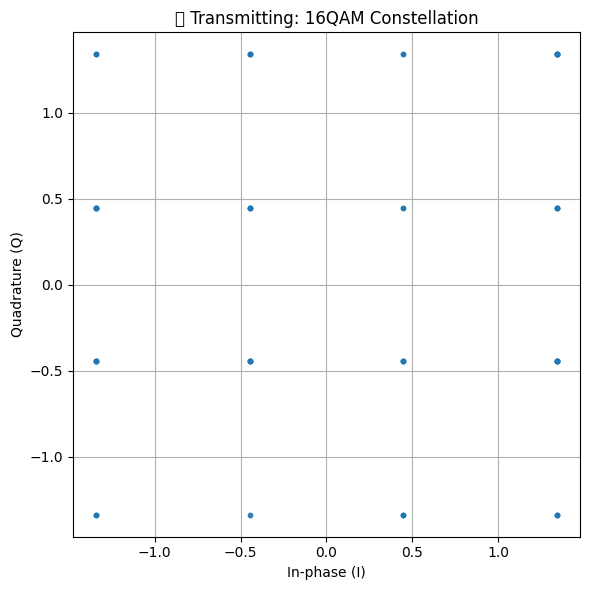

In [32]:
import matplotlib.pyplot as plt

iq_complex = synthetic_iq[0] + 1j * synthetic_iq[1]
plt.figure(figsize=(6, 6))
plt.plot(np.real(iq_complex), np.imag(iq_complex), '.', alpha=0.5)
plt.title(f"📡 Transmitting: {predicted_mod} Constellation")
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [37]:
import socket

def udp_sender(iq_data, ip="192.168.240.162", port=5005):
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    payload = iq_data.flatten().astype(np.float32).tobytes()
    sock.sendto(payload, (ip, port))
    sock.close()
    print(f" Sent {iq_data.shape[1]} I/Q samples to {ip}:{port} with {predicted_mod} modulation scheme")

udp_sender(synthetic_iq)



 Sent 128 I/Q samples to 192.168.240.162:5005 with 16QAM modulation scheme
